# Camera sensor profiling with NN
### www.datosimagensonido.com
[Calibración de cámara digital con redes neuronales](https://www.datosimagensonido.com/)

## Libraries needed

In [1]:
import os
# from skimage import io  # read/write image formats (incl. 16-bit TIFF)
import imageio  # read/write image formats (incl. 16-bit TIFF)
import pickle  # to save/load model

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPRegressor  # our MLP!

## Reading IT8 card white balanced RAW data

In [3]:
# RAW extraction with WB
# dcraw -v -r 2.299 1 1.805 1 -t 0 -o 0 -4 -T IT8.NEF

# Read image
# img = io.imread('IT8.tiff')
img = imageio.imread('IT8.tiff');

In [4]:
# Crop IT8 (6016 x 4016 pixels)
X1, X2 = 1201, 4810
Y1, Y2 = 832, 3240

img = img[Y1:Y2, X1:X2]

In [5]:
print(type(img))
print("RGB values range from", np.min(img), "to", np.max(img))
img.shape  # 24 x 16 squares -> 22 * 12 = 264 colour patches + 24 gray patches -> total: 288 examples

<class 'imageio.core.util.Array'>
RGB values range from 614 to 49076


(2408, 3609, 3)

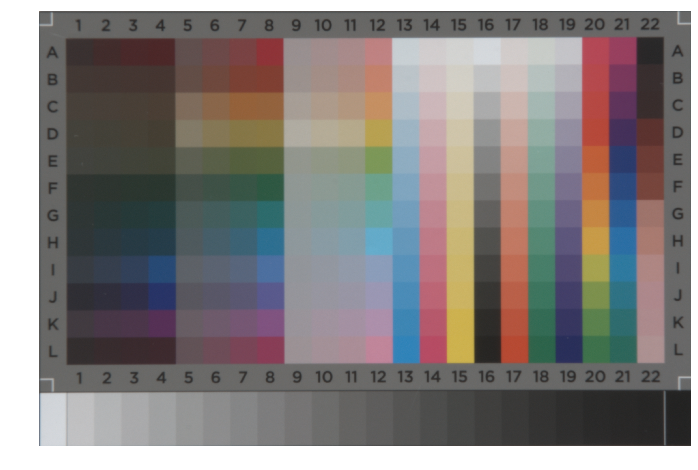

In [6]:
# Show IT8 chart
# Valid imshow range with RGB data: [0..1] for floats or [0..255] for integers
ZOOM = 4
plt.figure(figsize = (3 * ZOOM, 2 * ZOOM))
plt.imshow((img / 65535) ** (1 / 2.2))
plt.axis('off');

In [10]:
# Calculate median RGB values over each patch
width = img.shape[1] / 24
height = img.shape[0] / 16
dX, dY = width / 7, height / 7  # safety margin

colours = np.zeros((22 * 12, 3))
grays = np.zeros((24, 3))

# Colour patches
k = 0
for j in range(12):
    Y1, Y2 = round((j + 1) * height + dY), round((j + 2) * height - dY)
    for i in range(22):
        X1, X2 = round((i + 1) * width + dX), round((i + 2) * width - dX)
        for c in range(3):
            colours[k, c] = np.median(img[Y1:Y2, X1:X2, c])        
            img[(Y1 - 2):(Y2 + 2), (X1 - 2):(X2 + 2), c] = 0
            img[Y1:Y2, X1:X2, c] = colours[k, c]
        k = k + 1

# Gray patches
Y1, Y2 = round(14 * height + dY), round(16 * height - dY)
for i in range(24):
    X1, X2 = round((i + 0) * width + dX), round((i + 1) * width - dX)
    for c in range(3):
        grays[i, c] = np.median(img[Y1:Y2, X1:X2, c])
        img[(Y1 - 2):(Y2 + 2), (X1 - 2):(X2 + 2), c] = 0
        img[Y1:Y2, X1:X2, c] = grays[i, c]

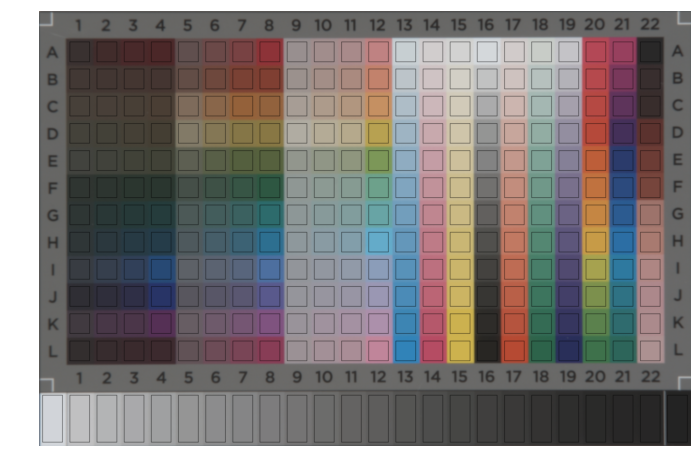

In [11]:
# Show used patches
# Valid imshow range with RGB data: [0..1] for floats or [0..255] for integers
ZOOM = 4
plt.figure(figsize = (3 * ZOOM, 2 * ZOOM))
plt.imshow((img / 65535) ** (1 / 2.2), interpolation='bilinear')
plt.axis('off');

In [9]:
# Save image
# io.imsave('IT8_crop_median.tif', img)
imageio.imwrite('IT8_crop_median.tif', img)

In [10]:
# Features: X (RGB RAW + WB)
R1 = colours[:, 0].flatten()
G1 = colours[:, 1].flatten()
B1 = colours[:, 2].flatten()

R2 = grays[:, 0].flatten()
G2 = grays[:, 1].flatten()
B2 = grays[:, 2].flatten()

X = np.concatenate((np.column_stack((R1, G1, B1)),
                    np.column_stack((R2, G2, B2)))) / 65535  # WB-RAW RGB in 0..1 range

## Reading IT8 card XYZ/Lab theoretical output values

In [87]:
# 288 patches: 264 (0..263 = A1..L22) colour + 24 (264..287 = GS0..GS23) gray

In [2]:
# Target: Y
IT8 = pd.read_csv('IT8.txt', sep='\t', decimal=',')
IT8.head()

,Patch,X,Y,Z,L,a,b
0,A1,3.273115,2.815129,1.956762,19.2878,9.7909,3.3837
1,A2,3.998580,2.721619,1.417480,18.8926,22.6662,8.5572
2,A3,4.991359,2.802497,1.360139,19.2349,34.4691,9.8527
3,A4,5.137458,2.693988,1.131962,18.7742,38.2558,12.0804
4,A5,12.086800,10.629437,7.330434,38.9492,13.3835,5.5036


In [3]:
Y_XYZ = IT8[['X', 'Y', 'Z']].values / 100  # XYZ in the 0..1 range
Y_Lab = IT8[['L', 'a', 'b']].values        # Lab in the Lab range

## Training the neural network

In [49]:
# Define all NN's
NN = []
for struct in [(), (3, 3), (50, 50), (200, 200), (200, 200, 200)]:
    for activation in ['relu', 'logistic']:
        for out_activation in ['identity']:
            for output in ['XYZ', 'Lab']:
                NN.append([struct, activation, out_activation, output])
                
for i in range(len(NN)):
    print(NN[i])

[(), 'relu', 'identity', 'XYZ']
[(), 'relu', 'identity', 'Lab']
[(), 'logistic', 'identity', 'XYZ']
[(), 'logistic', 'identity', 'Lab']
[(3, 3), 'relu', 'identity', 'XYZ']
[(3, 3), 'relu', 'identity', 'Lab']
[(3, 3), 'logistic', 'identity', 'XYZ']
[(3, 3), 'logistic', 'identity', 'Lab']
[(50, 50), 'relu', 'identity', 'XYZ']
[(50, 50), 'relu', 'identity', 'Lab']
[(50, 50), 'logistic', 'identity', 'XYZ']
[(50, 50), 'logistic', 'identity', 'Lab']
[(200, 200), 'relu', 'identity', 'XYZ']
[(200, 200), 'relu', 'identity', 'Lab']
[(200, 200), 'logistic', 'identity', 'XYZ']
[(200, 200), 'logistic', 'identity', 'Lab']
[(200, 200, 200), 'relu', 'identity', 'XYZ']
[(200, 200, 200), 'relu', 'identity', 'Lab']
[(200, 200, 200), 'logistic', 'identity', 'XYZ']
[(200, 200, 200), 'logistic', 'identity', 'Lab']


In [ ]:
# Train all NN's
for i in range(len(NN)):
    nn = NN[i]
    regr = MLPRegressor(solver='adam', # solver algorithm ('sgd', 'lbfgs', 'adam')
                        alpha=0,        # no L2 (ridge regression) regularization
                        hidden_layer_sizes=nn[0],  # tuple defining layers and nodes
                        # early_stopping=True,
                        # validation_fraction=0.05,
                        activation=nn[1],      # hidden layers activation function (default 'relu') 
                                                # 'logistic' (sigmoid) works better than 'relu' and 'tanh'
                        max_iter=20800,  # max_iter=20800,         # max epochs
                        tol=0.000000000001,     # tolerance for early stopping
                        n_iter_no_change=10000,  # number of epochs to check tol
                        random_state=42,        # guarantee reproducible training
                        verbose=True)           # tell me a story
    regr.out_activation_ = nn[2]  # output layer activation function (default 'identity')
                                       # 'identity' is adequate for regression
    if nn[3] == 'XYZ':
        regr.fit(X, Y_XYZ)
    else:
        regr.fit(X, Y_Lab)        
    
    # Save MLP
    nn_name = 'MLP_' + nn[3] + '_' + str(nn[0]) + '_' + nn[1] + '_' + nn[2]
    with open(nn_name + '.pkl', 'wb') as f:
        pickle.dump(regr, f)
    

In [165]:
# MLP weights -> WB-RAW RGB to XYZ 3x3 matrix conversion
regr.coefs_

[array([[ 0.79443793,  0.35856019,  0.06022069],
        [ 0.2781231 ,  0.99655999, -0.26346605],
        [ 0.12676705, -0.11509048,  1.21852841]])]

In [13]:
# MLP biases -> nearly 0's
regr.intercepts_

[array([-0.01059187, -0.00989786, -0.00368542])]

### Plot and save Loss vs Epochs

In [ ]:
# Load MLP (once trained and saved)
for i in range(len(NN)):
    nn = NN[i]
    nn_name = 'MLP_' + nn[3] + '_' + str(nn[0]) + '_' + nn[1] + '_' + nn[2]
    with open(nn_name + '.pkl', 'rb') as f:
        regr = pickle.load(f)

    # Plot error vs epoch
    plt.clf()
    plt.plot(regr.loss_curve_)
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.savefig(nn_name + '_LOSS.png')

## Neural network prediction

In [ ]:
# Load MLP (once trained and saved)
for i in range(len(NN)):
    nn = NN[i]
    nn_name = 'MLP_' + nn[3] + '_' + str(nn[0]) + '_' + nn[1] + '_' + nn[2]
    with open(nn_name + '.pkl', 'rb') as f:
        regr = pickle.load(f)

    # Prediction
    Y_pred = regr.predict(X)
    
    # Clip to 0..1 range
    # Y_pred[Y_pred < 0] = 0.0
    # Y_pred[Y_pred > 1] = 1.0

    if nn[3] == 'XYZ':
        Y = Y_XYZ
        label1, label2, label3 = 'X', 'Y', 'Z'
    else:
        Y = Y_Lab
        label1, label2, label3 = 'L', 'a', 'b'
        
    # Plot error vs epoch
    plt.clf()
    plt.subplots(figsize=(13, 4))

    plt.subplot(131)
    plt.scatter(Y[:, 0], Y_pred[:, 0], alpha=0.2)
    plt.xlabel('Real ' + label1)
    plt.ylabel('Predicted ' + label1)

    plt.subplot(132)
    plt.scatter(Y[:, 1], Y_pred[:, 1], alpha=0.2)
    plt.xlabel('Real ' + label2)
    plt.ylabel('Predicted ' + label2)

    plt.subplot(133)
    plt.scatter(Y[:, 2], Y_pred[:, 2], alpha=0.2)
    plt.xlabel('Real ' + label3)
    plt.ylabel('Predicted ' + label3)
    
    plt.savefig(nn_name + '_CORR.png')

## Conversion functions

### XYZ (D50) to Lab conversion

In [8]:
def XYZ_to_Lab(XYZ):  # XYZ is a Nx3 array in the 0..1 range
    """XYZ (D50) to Lab conversion
    Formulae from www.brucelindbloom.com
    """
    
    Xr = 0.96422  # D50/2° 1931 reference white
    Yr = 1.0
    Zr = 0.82521
    
    e = 0.008856
    k = 903.3

    xr = XYZ[:, 0] / Xr
    yr = XYZ[:, 1] / Yr
    zr = XYZ[:, 2] / Zr
    
    # Most usual cases (xr > e, yr > e, zr > e)
    fx = xr ** (1 / 3)
    fy = yr ** (1 / 3)
    fz = zr ** (1 / 3)
    
    # Least usual cases
    indx = tuple([xr <= e])  # not using tuple() works but is deprecated
    indy = tuple([yr <= e])
    indz = tuple([zr <= e])
        
    fx[indx] = (k * xr[indx] + 16) / 116
    fy[indy] = (k * yr[indy] + 16) / 116
    fz[indz] = (k * zr[indz] + 16) / 116
        
    L = 116 * fy - 16
    a = 500 * (fx - fy)
    b = 200 * (fy - fz)
        
    return np.column_stack((L, a, b))  # output is a Nx3 array in the Lab range

In [26]:
# Test 1
XYZ_to_Lab(np.array([[0.5, 0.7, 0.2]]))

array([[ 86.9968642 , -42.25249828,  52.88499815]])

In [43]:
# Test 2: return ticket
Lab = XYZ_to_Lab(Y_XYZ)
Y_XYZ_bis = Lab_to_XYZ(Lab)
np.max(Y_XYZ_bis - Y_XYZ)

2.7755575615628914e-16

### Lab to XYZ (D50) conversion

In [4]:
def Lab_to_XYZ(Lab):  # Lab is a Nx3 array in the Lab range
    """Lab to XYZ (D50) conversion
    Formulae from www.brucelindbloom.com
    """
    
    Xr = 0.96422  # D50/2° 1931 reference white
    Yr = 1.0
    Zr = 0.82521
    
    e = 0.008856
    k = 903.3
    
    L = Lab[:, 0]
    a = Lab[:, 1]
    b = Lab[:, 2]
    
    fy = (L + 16) / 116
    fx = a / 500 + fy
    fz = fy - b / 200
    
    # Most usual cases (fx^3 > e, L > ke, fz^3 > e)
    xr = fx ** 3
    yr = ((L + 16) / 116)  ** 3
    zr = fz ** 3
    
    # Least usual cases
    indx = tuple([fx ** 3 <= e])  # not using tuple() works but is deprecated
    indy = tuple([L <= k * e])
    indz = tuple([fz ** 3 <= e])
    
    xr[indx] = (116 * fx[indx] - 16) / k
    yr[indy] = L[indy] / k
    zr[indz] = (116 * fz[indz] - 16) / k
    
    X = xr * Xr
    Y = yr * Yr
    Z = zr * Zr
    
    return np.column_stack((X, Y, Z))  # output is a Nx3 array in the 0..1 range

In [28]:
# Test 1
Lab_to_XYZ(np.array([[86.9968642, -42.25249828, 52.88499815]]))

array([[0.5, 0.7, 0.2]])

In [44]:
# Test 2: return ticket
XYZ = Lab_to_XYZ(Y_Lab)
Y_Lab_bis = XYZ_to_Lab(XYZ)
np.max(Y_Lab_bis - Y_Lab)

6.838973831690964e-14

In [41]:
# Test 3:
np.max(Y_Lab - XYZ_to_Lab(Y_XYZ))

0.004186399228351956

In [42]:
# Test 4:
np.max(Lab_to_XYZ(Y_Lab) - Y_XYZ)

1.0632757984074814e-06

### XYZ (D50) to sRGB (D65) conversion

In [5]:
def XYZ_to_sRGB(XYZ):  # XYZ is a Nx3 array in the 0..1 range
    """XYZ (D50) to sRGB (D65) conversion using D50 to D65 Bradford adaption
    Formulae from www.brucelindbloom.com
    """
    
    X = XYZ[:, 0]
    Y = XYZ[:, 1]
    Z = XYZ[:, 2]
    
    r = 3.1338561 * X - 1.6168667 * Y - 0.4906146 * Z
    g =-0.9787684 * X + 1.9161415 * Y + 0.0334540 * Z
    b = 0.0719453 * X - 0.2289914 * Y + 1.4052427 * Z
    
    # Clip to 0..1 range
    r[r < 0] = 0.0
    r[r > 1] = 1.0
    g[g < 0] = 0.0
    g[g > 1] = 1.0
    b[b < 0] = 0.0
    b[b > 1] = 1.0
    
    # Most usual cases (R, G, B > 0.0031308)
    R = 1.055 * r**(1 / 2.4) - 0.055
    G = 1.055 * g**(1 / 2.4) - 0.055
    B = 1.055 * b**(1 / 2.4) - 0.055
    
    # Least usual cases
    indr = tuple([R <= 0.0031308])  # not using tuple() works but is deprecated
    indg = tuple([G <= 0.0031308])
    indb = tuple([B <= 0.0031308])
    
    R[indr] = 12.92 * R[indr]
    G[indg] = 12.92 * R[indg]
    B[indb] = 12.92 * R[indb]
    
    return np.column_stack((R, G, B))  # output is a Nx3 array in the 0..1 range

In [31]:
# Test 1
XYZ_to_sRGB(np.array([[0.5, 0.7, 0.2]])) * 255

array([[156.96508483, 238.44320903, 110.26498658]])

### XYZ (D50) to ProPhoto RGB (D50) conversion

In [6]:
def XYZ_to_ProPhotoRGB(XYZ):  # XYZ is a Nx3 array in the 0..1 range
    """XYZ (D50) to ProPhoto RGB (D50) conversion (no adaption needed)
    Formulae from www.brucelindbloom.com
    """
    
    X = XYZ[:, 0]
    Y = XYZ[:, 1]
    Z = XYZ[:, 2]
    
    r = 1.3459433 * X - 0.2556075 * Y - 0.0511118 * Z
    g =-0.5445989 * X + 1.5081673 * Y + 0.0205351 * Z
    b = 0.0000000 * X + 0.0000000 * Y + 1.2118128 * Z
    
    # Clip to 0..1 range
    r[r < 0] = 0.0
    r[r > 1] = 1.0
    g[g < 0] = 0.0
    g[g > 1] = 1.0
    b[b < 0] = 0.0
    b[b > 1] = 1.0
    
    return np.column_stack((r, g, b)) ** (1 / 1.8)  # output is a Nx3 array in the 0..1 range

In [33]:
# Test 1:
XYZ_to_ProPhotoRGB(np.array([[0.5, 0.7, 0.2]])) * 255

array([[170.35957108, 223.31051101, 116.03168168]])

### Delta E calculation

In [9]:
def DeltaE(Lab1, Lab2):  # Lab1 and Lab2 are Nx3 arrays in the Lab range
    """Delta E calculation
       ΔE Quality:
         <1 = Excellent (imperceptible)
        1-2 = Good
        2-4 = Normal
        4-5 = Sufficient
         >5 = Bad
    """
    
    return np.sqrt((Lab1[:, 0] - Lab2[:, 0]) ** 2 +
                   (Lab1[:, 1] - Lab2[:, 1]) ** 2 +
                   (Lab1[:, 2] - Lab2[:, 2]) ** 2)  # ouput is a Nx1 array in the Lab range

## MLP models comparison

In [ ]:
# Load MLP (once trained and saved)
for i in range(len(NN)):
    nn = NN[i]
    nn_name = 'MLP_' + nn[3] + '_' + str(nn[0]) + '_' + nn[1] + '_' + nn[2]
    with open(nn_name + '.pkl', 'rb') as f:
        regr = pickle.load(f)

    # Prediction
    Y_pred = regr.predict(X)
    
    # Clip to 0..1 range
    # Y_pred[Y_pred < 0] = 0.0
    # Y_pred[Y_pred > 1] = 1.0

    if nn[3] == 'XYZ':
        Y_pred = XYZ_to_Lab(Y_pred)  # convert to Lab all XYZ models
    
    DeltaE_ = DeltaE(Y_Lab, Y_pred)

    print(nn_name,
          ": ΔE_max = %.4f" % np.max(DeltaE_),
          ", ΔE_mean = %.4f" % np.mean(DeltaE_),
          ", ΔE_median = %.4f" % np.median(DeltaE_))
    
    # Plot Delta E distribution
    plt.rcParams.update({'figure.max_open_warning': 0})  # get rid of warnings
    plt.clf()
    plt.subplots(figsize=(13, 5))
    plt.hist(DeltaE_, bins=150, range=[0, 8], color='b', alpha=0.5)
    plt.savefig(nn_name + '_HIST.png')  

## MLP images output

In [10]:
# We keep the best model: "MLP_Lab_(200, 200)_relu_identity"
# with open('MLP_Lab_(200, 200)_relu_identity.pkl', 'rb') as f:
with open('MLP_Lab_(50, 50)_logistic_identity.pkl', 'rb') as f:  # best compromise complexity vs performance
    regr = pickle.load(f)

In [12]:
img = imageio.imread('IT8.tiff')  # RGB RAW + WB

# Crop IT8 (6016 x 4016 pixels)
X1, X2 = 1201, 4810
Y1, Y2 = 832, 3240

img = img[Y1:Y2, X1:X2]

In [14]:
# Flatten
R = img[:, :, 0].flatten()
G = img[:, :, 1].flatten()
B = img[:, :, 2].flatten()

In [15]:
X_train = np.column_stack((R, G, B)) / 65535

In [16]:
del img, R, G, B  # save memory

In [18]:
# Prediction
Y_pred = regr.predict(X_train)  # Lab values

In [20]:
# Reshape as (Lab) image
HEIGHT = 2408
WIDTH = 3609

L_pred = Y_pred[:, 0].reshape(HEIGHT, WIDTH)
a_pred = Y_pred[:, 1].reshape(HEIGHT, WIDTH)
b_pred = Y_pred[:, 2].reshape(HEIGHT, WIDTH)

img = np.zeros((HEIGHT, WIDTH, 3), dtype=np.float64)
img[:, :, 0] = L_pred
img[:, :, 1] = a_pred
img[:, :, 2] = b_pred

In [21]:
# Write Y_Lab values on half rectangles of img
width = img.shape[1] / 24
height = img.shape[0] / 16
dX, dY = width / 7, height / 7  # safety margin

# Colour patches
k = 0
for j in range(12):
    Y1, Y2 = round((j + 1) * height + dY), round((j + 2) * height - dY)
    for i in range(22):
        X1, X2 = round((i + 1) * width + width / 2), round((i + 2) * width - dX)
        for c in range(3):
            img[Y1:Y2, X1:X2, c] = Y_Lab[k, c]
        k = k + 1

# Gray patches
Y1, Y2 = round(14 * height + dY), round(16 * height - dY)
for i in range(24):
    X1, X2 = round((i + 0) * width + width / 2), round((i + 1) * width - dX)
    for c in range(3):
        img[Y1:Y2, X1:X2, c] = Y_Lab[k, c]
    k = k + 1
    
print("k =", k)        

k = 288


In [22]:
# Flatten
L = img[:, :, 0].flatten()
a = img[:, :, 1].flatten()
b = img[:, :, 2].flatten()

In [23]:
Y_pred = np.column_stack((L, a, b))

In [24]:
Y_pred_ProPhotoRGB = XYZ_to_ProPhotoRGB(Lab_to_XYZ(Y_pred))  # nested Lab -> XYZ -> ProPhoto RGB conversion

In [25]:
# Build prediction image
HEIGHT = 2408
WIDTH = 3609

R_pred = Y_pred_ProPhotoRGB[:, 0].reshape(HEIGHT, WIDTH)
G_pred = Y_pred_ProPhotoRGB[:, 1].reshape(HEIGHT, WIDTH)
B_pred = Y_pred_ProPhotoRGB[:, 2].reshape(HEIGHT, WIDTH)

prediction = np.zeros((HEIGHT, WIDTH, 3), dtype=np.float64)
prediction[:, :, 0] = R_pred
prediction[:, :, 1] = G_pred
prediction[:, :, 2] = B_pred

In [26]:
prediction = np.round(prediction * 65535).astype('uint16')  # range [0..65535]

In [27]:
# Save image
# io.imsave('IT8_pred_ProPhotoRGB.tif', prediction)
imageio.imwrite('IT8_pred_ProPhotoRGB_comp.tif', prediction)